# Pokemon Go Project
### Samuel Freeman, Sahil Raina, Alexander Wilson

### Imports

In [1]:
import pandas as pd
from bs4 import BeautifulSoup 
import unidecode
import collections
from django.utils.encoding import smart_str, smart_unicode
import re
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.figure as fig
import pickle
import json
import string

### These are functions that were used in the page scraping that helped get good, consistent results
    1. double_digit() takes any number input and returns a two digit string.  This allowed us to iterate through numeric values, but ensure that something that was a 1, could be treated as '01'
    2. cleanhtml() removes all html tags from a section of text
    3. converU() uses the django tools to convert unicode strings to ASCII strings with the most consistent results of any method we have attempted to use

In [2]:
def double_digit(orig):
    if len(orig)<2:
        return(double_digit('0'+orig))
    else:
        return(orig)

def cleanhtml(raw_html):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', raw_html)
    return cleantext

def convertU(data):
    if isinstance(data, basestring):
        return smart_str(data)
    elif isinstance(data, collections.Mapping):
        return dict(map(convertU, data.iteritems()))
    elif isinstance(data, collections.Iterable):
        return type(data)(map(convertU, data))
    else:
        return data

## Extract from iOS
    These functions consistently returned the correct data from the page in question

In [3]:
def get_ratings(soup):
    rating_spans = soup.find_all("span",{"class":"rating-count"})
    ratings = []
    for span in rating_spans:
        ratings.append(int(re.findall('\d+', cleanhtml(str(span)))[0]))
    if len(ratings)==1:
        return(0,ratings[0])  
    elif ratings[0]<ratings[1]:
        return(ratings[0],ratings[1])
    else:
        return(ratings[1],ratings[0])

def get_size(soup):
    size_lis = soup.find_all("li")
    for li in size_lis:
        li_spans= li.find_all("span",{"class":"label"})
        if len(li_spans) >0:
            if "Size" in cleanhtml(str(li_spans)):
                return(int(re.findall('\d+', cleanhtml(str(li)))[0]))

def get_description(soup):
    desc_ps = soup.find_all("p",{"itemprop":"description"})
    return(cleanhtml(str(desc_ps[0])))

def get_version(soup):
    vers_spans = soup.find_all("span",{"itemprop":"softwareVersion"})
    return(cleanhtml(str(vers_spans[0])))

### Issues identified during attempts:
    1. Many of the given files were not corretly named in accordance with the convetion outlined in the instructions.  Those files were manually corrected so that they were scraped and included in the dataset

In [11]:
ios_df = pd.DataFrame(columns = ['dtg','curr_ratings','tot_ratings','size','desc','ver'])
ios_eod = pd.DataFrame(columns = ['dtg','curr_rating','tot_rating','size'])

row = 0
day = 0 
for mo in range(7,11):
    for da in range(1,32):
        for hr in range(0,24):
            for mn in range(0,60,10):
                try:
                    soup = BeautifulSoup(open("C:\\Users\\ajwil\\OneDrive\\Documents\\00_public\\00_Pokemon_Go_Project\\data\\2016-{}-{}\\{}_{}_pokemon_ios.html".format(double_digit(str(mo)),double_digit(str(da)),double_digit(str(hr)),double_digit(str(mn)))), "lxml")

                    ios_df.loc[row]=[datetime.strptime("2016-{}-{}.{}:{}".format(double_digit(str(mo)),double_digit(str(da)),double_digit(str(hr)),double_digit(str(mn))),'%Y-%m-%d.%H:%M'),
                                     get_ratings(soup)[0],
                                     get_ratings(soup)[1],
                                     get_size(soup),
                                     get_description(soup),
                                     get_version(soup)]
                    row+=1
                    if "{}_{}".format(double_digit(str(hr)),double_digit(str(mn))) == "23_50":
                        ios_eod.loc[day]=[datetime.strptime("2016-{}-{}.{}:{}".format(double_digit(str(mo)),double_digit(str(da)),double_digit(str(hr)),double_digit(str(mn))),'%Y-%m-%d.%H:%M'),
                                          get_ratings(soup)[0],
                                          get_ratings(soup)[1],
                                          get_size(soup)]
                        day+=1                        
                except:
                    #print("Did not complete for 2016-{}-{}.{}-{}".format(double_digit(str(mo)),double_digit(str(da)),double_digit(str(hr)),double_digit(str(mn))))
                    continue
print(row)
print(day)

14810
103


### iOS Data Visualizations
This visualization is followed the instructions for the required visualization of the iOS numeric data, but the data does not graph well together because of the vastly different scales of the data

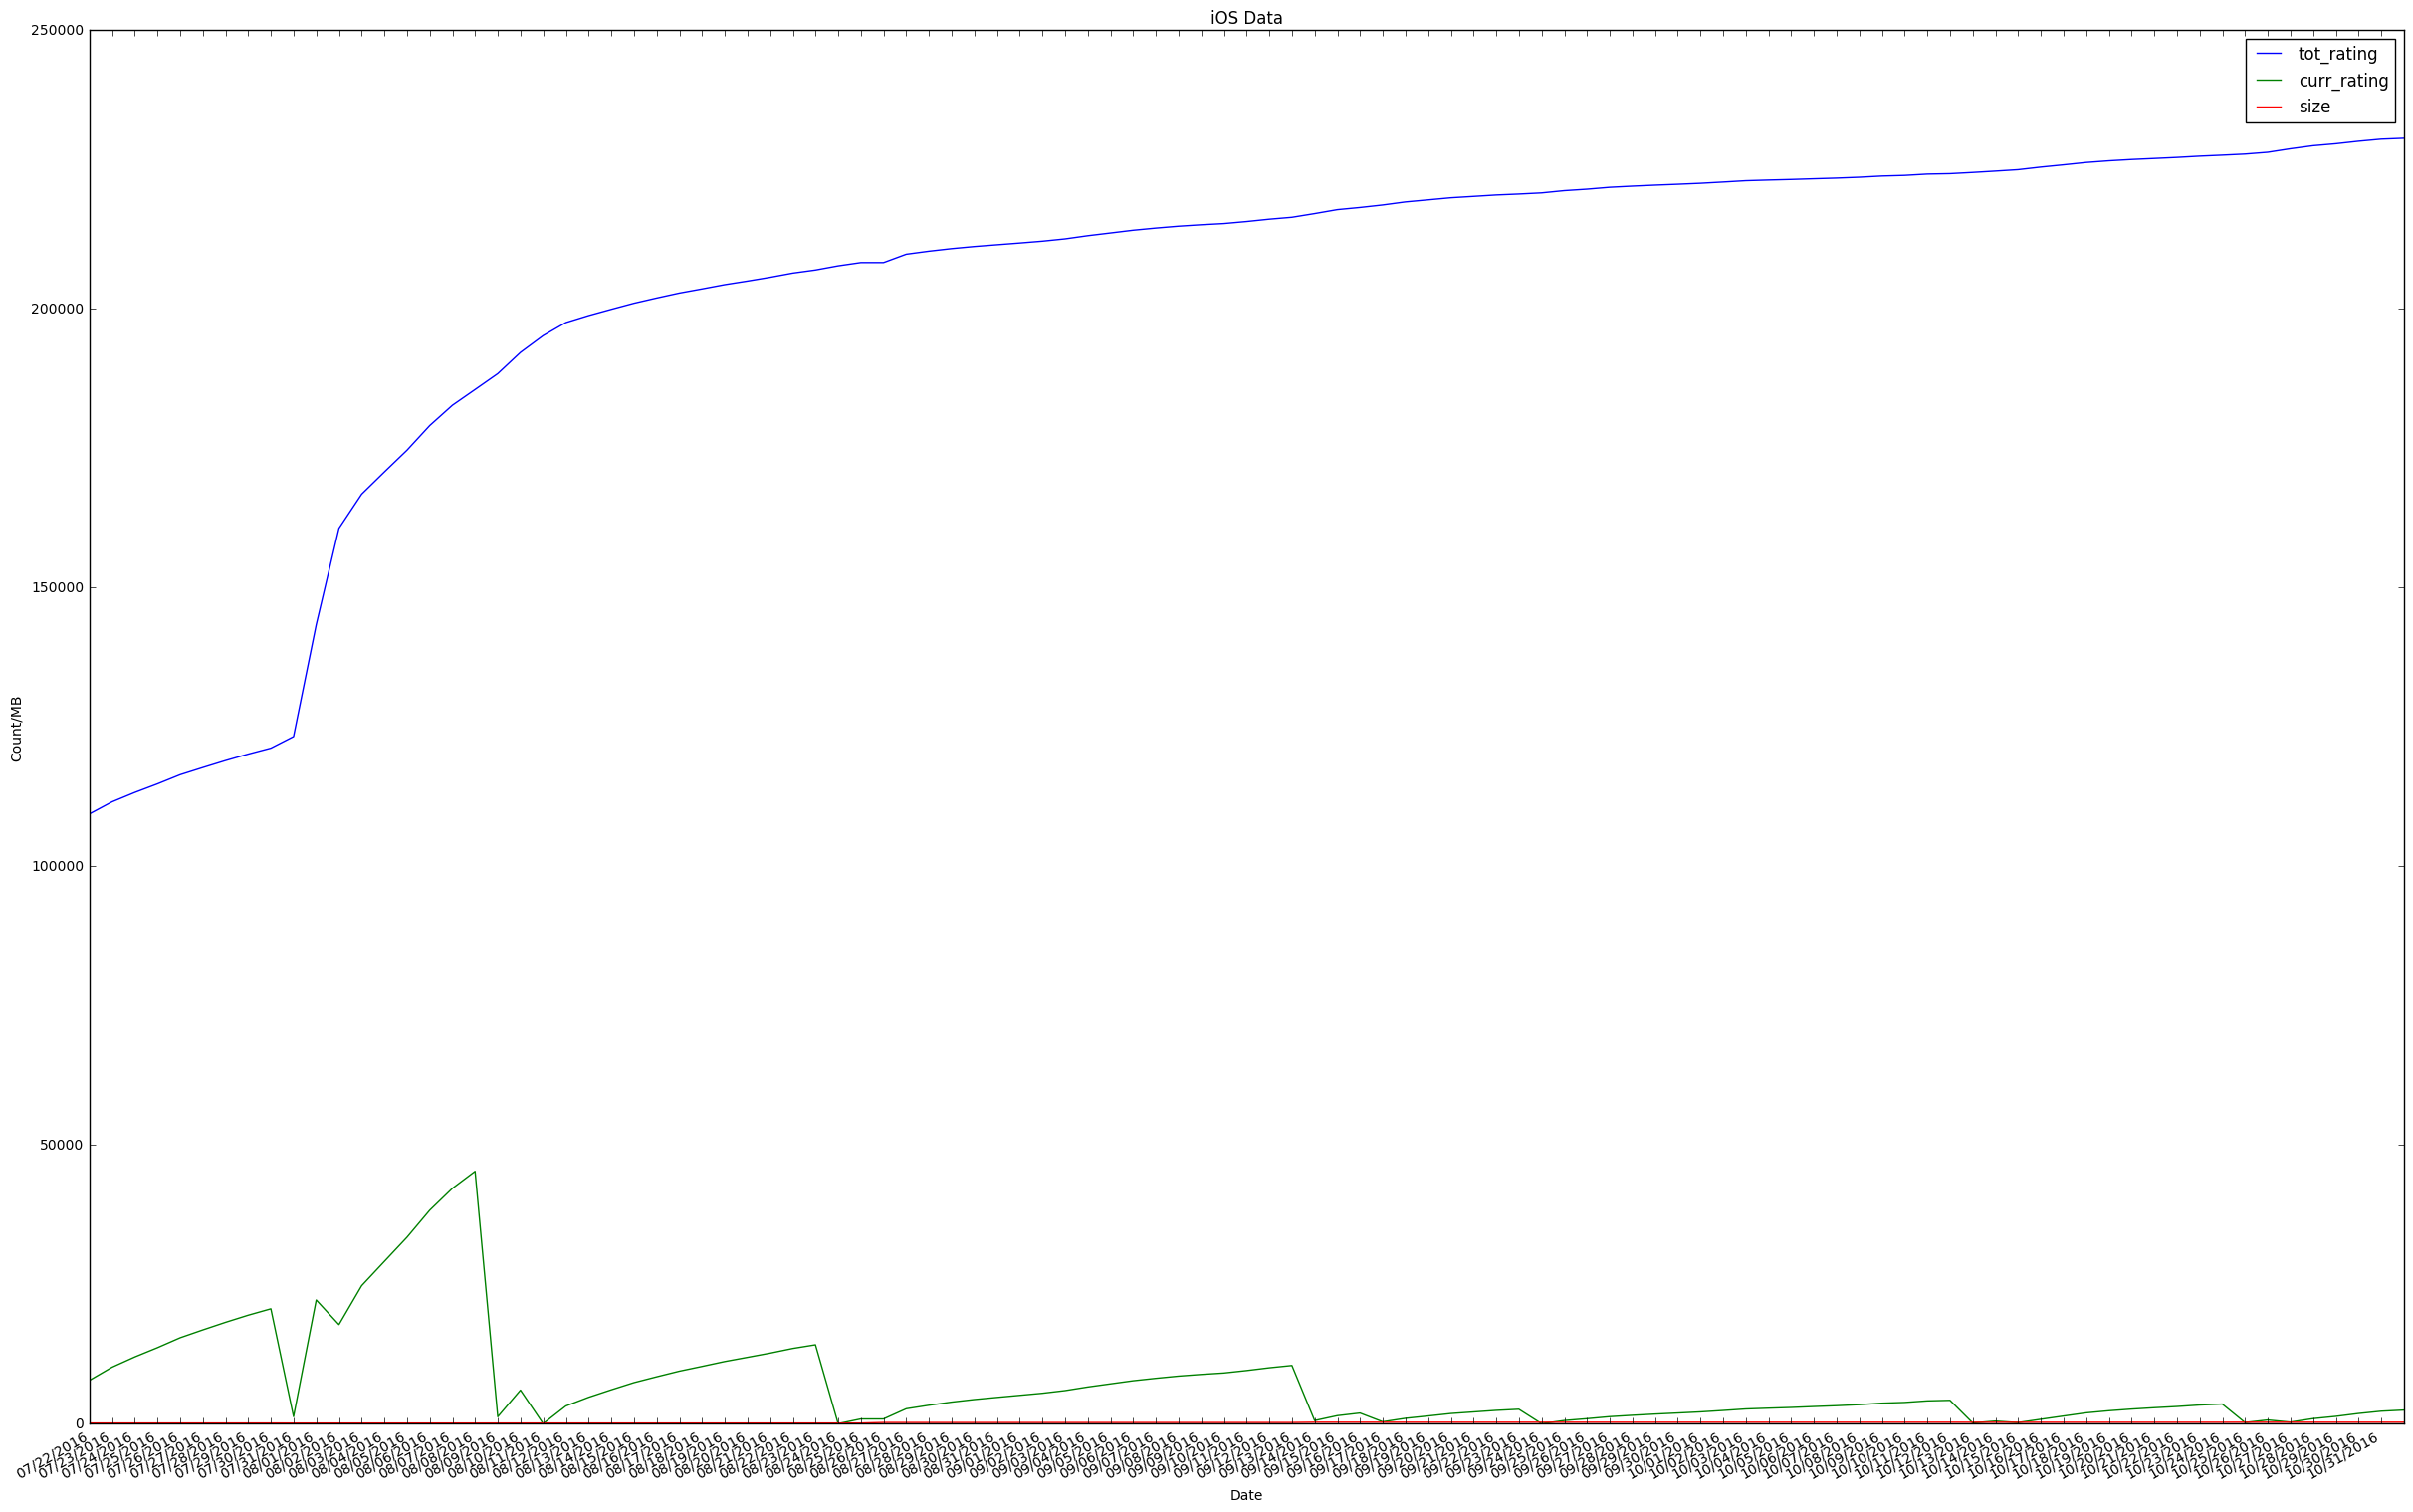

In [43]:
plt.subplots(figsize=(30,20))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.plot(ios_eod['dtg'],ios_eod['tot_rating'])
plt.plot(ios_eod['dtg'],ios_eod['curr_rating'])
plt.plot(ios_eod['dtg'],ios_eod['size'])
plt.xlabel('Date')
plt.ylabel('Count/MB')
plt.legend()
plt.title('iOS Data')
plt.gcf().autofmt_xdate()

plt.savefig('iOS.png', dpi = 400)
plt.show()

## Extract from Android
These functions consistently extracted the data from the Android pages, except in the instances when the data was not actually found on the page

In [5]:
def get_avg_android_score(soup):
    divs = soup.find_all("div",{"class":"score"})
    return(float(cleanhtml(str(divs[0]))))

def get_android_ratings(soup):
    hist_divs = soup.find_all("div",{"class":"rating-histogram"})
    scores = []
    for div in hist_divs:
        div_spans= div.find_all("span",{"class":"bar-number"})
        for div in div_spans:
            scores.append(int(cleanhtml(str(div)).replace(',','')))
    return(scores[4],scores[3],scores[2],scores[1],scores[0])

def get_total_android_ratings(soup):
    spans = soup.find_all("span",{"class":"reviews-num"})
    return(int(cleanhtml(str(spans[0])).replace(',','')))

def get_android_size(soup):
    divs = soup.find_all('div',{"itemprop":"fileSize"})
    return(int(re.findall('\d+',cleanhtml(str(divs[0])))[0]))

def get_android_version(soup):
    divs = soup.find_all('div',{"itemprop":"softwareVersion"})
    return(cleanhtml(str(divs[0])))

def get_android_desc(soup):
    divs = soup.find_all('div',{"itemprop":"description"})
    return(cleanhtml(str(divs[0])))

There were a number of instances when the required information was not on the page for a hour or more.  In these instances, we appended None to the data frame in place of the missing data

In [5]:
and_df = pd.DataFrame(columns = ['dtg','avg_score','total_ratings','one_star','two_star','three_star','four_star','five_star','size','version','desc'])
and_eod = pd.DataFrame(columns = ['dtg','avg_score','total_ratings','one_star','two_star','three_star','four_star','five_star','size','version','desc'])
row = 0
day = 0 
for mo in range(7,11):
    for da in range(1,32):
        for hr in range(0,24):
            for mn in range(0,60,10):
                try:
                    soup = BeautifulSoup(open("C:\\Users\\ajwil\\OneDrive\\Documents\\00_public\\00_Pokemon_Go_Project\\data\\2016-{}-{}\\{}_{}_pokemon_android.html".format(double_digit(str(mo)),double_digit(str(da)),double_digit(str(hr)),double_digit(str(mn)))), "lxml")

                    temp_dtg = datetime.strptime("2016-{}-{}.{}:{}".format(double_digit(str(mo)),double_digit(str(da)),double_digit(str(hr)),double_digit(str(mn))),'%Y-%m-%d.%H:%M')
                    try:
                        temp_scores = get_android_ratings(soup)
                    except:
                        temp_scores = (None,None,None,None,None)
                    try:
                        temp_avg = get_avg_android_score(soup)
                    except:
                        temp_avg=None
                    try:
                        temp_tot_ratings = get_total_android_ratings(soup)
                    except:
                        temp_tot_ratings = None
                    try:
                        temp_size = get_android_size(soup)
                    except:
                        temp_size = None
                    try:
                        temp_version = get_android_version(soup)
                    except:
                        temp_version = None
                    try:
                        temp_desc = get_android_desc(soup)
                    except:
                        temp_desc = None
                    
                    
                    and_df.loc[row]=[temp_dtg,temp_avg,temp_tot_ratings,temp_scores[0],temp_scores[1],
                                    temp_scores[2],temp_scores[3],temp_scores[4],temp_size,temp_version,temp_desc]
                    row+=1
                    if "{}_{}".format(double_digit(str(hr)),double_digit(str(mn))) == "23_50":
                        
                        and_eod.loc[day]=[temp_dtg,temp_avg,temp_tot_ratings,temp_scores[0],temp_scores[1],
                                    temp_scores[2],temp_scores[3],temp_scores[4],temp_size,temp_version,temp_desc]
                        day+=1                        
                except:
                    #print("Did not complete for 2016-{}-{}.{}-{}".format(double_digit(str(mo)),double_digit(str(da)),double_digit(str(hr)),double_digit(str(mn))))
                    continue
print(row)
print(day)

14810
103


### Plot of the comparative size of the Android and iOS files

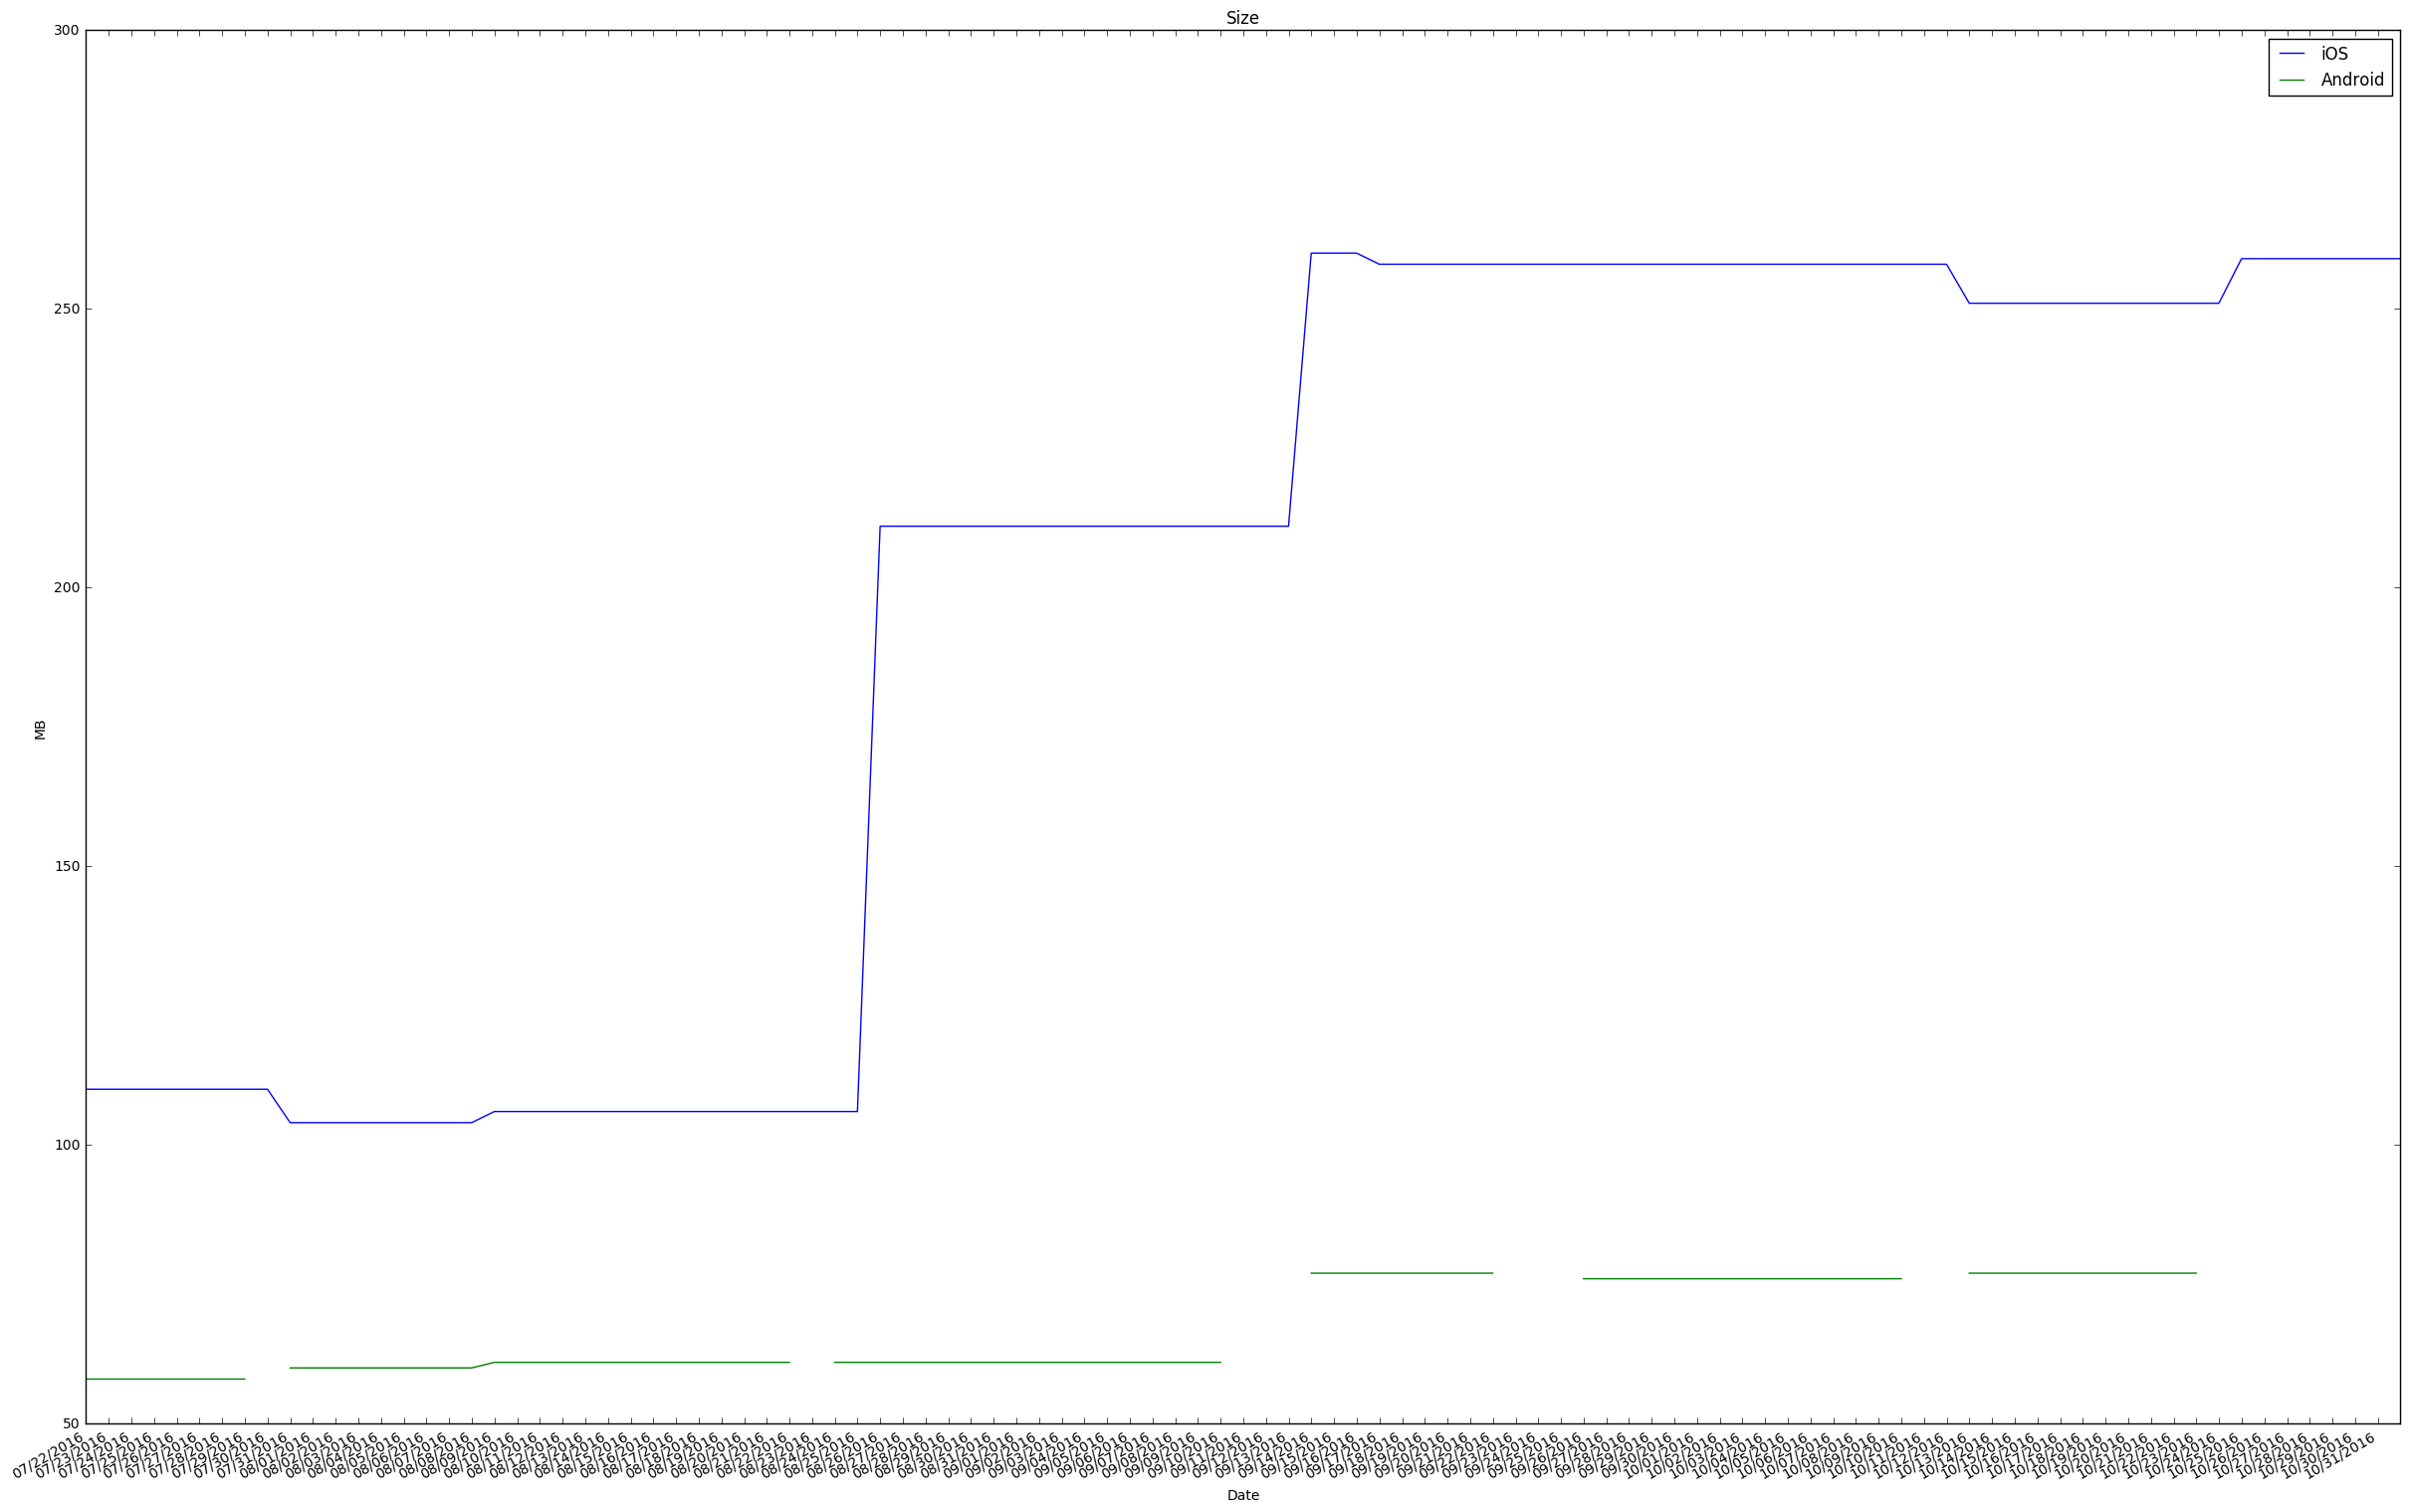

In [40]:
plt.subplots(figsize=(30,20))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.plot(ios_eod['dtg'],ios_eod['size'])
plt.plot(and_eod['dtg'],and_eod['size'])
plt.legend(labels=['iOS','Android'])
plt.xlabel('Date')
plt.ylabel('MB')
plt.title('Size')
plt.gcf().autofmt_xdate()

plt.savefig('size.png', dpi = 400)
plt.show()

### Comparative graph of the total ratings recorded for each device type

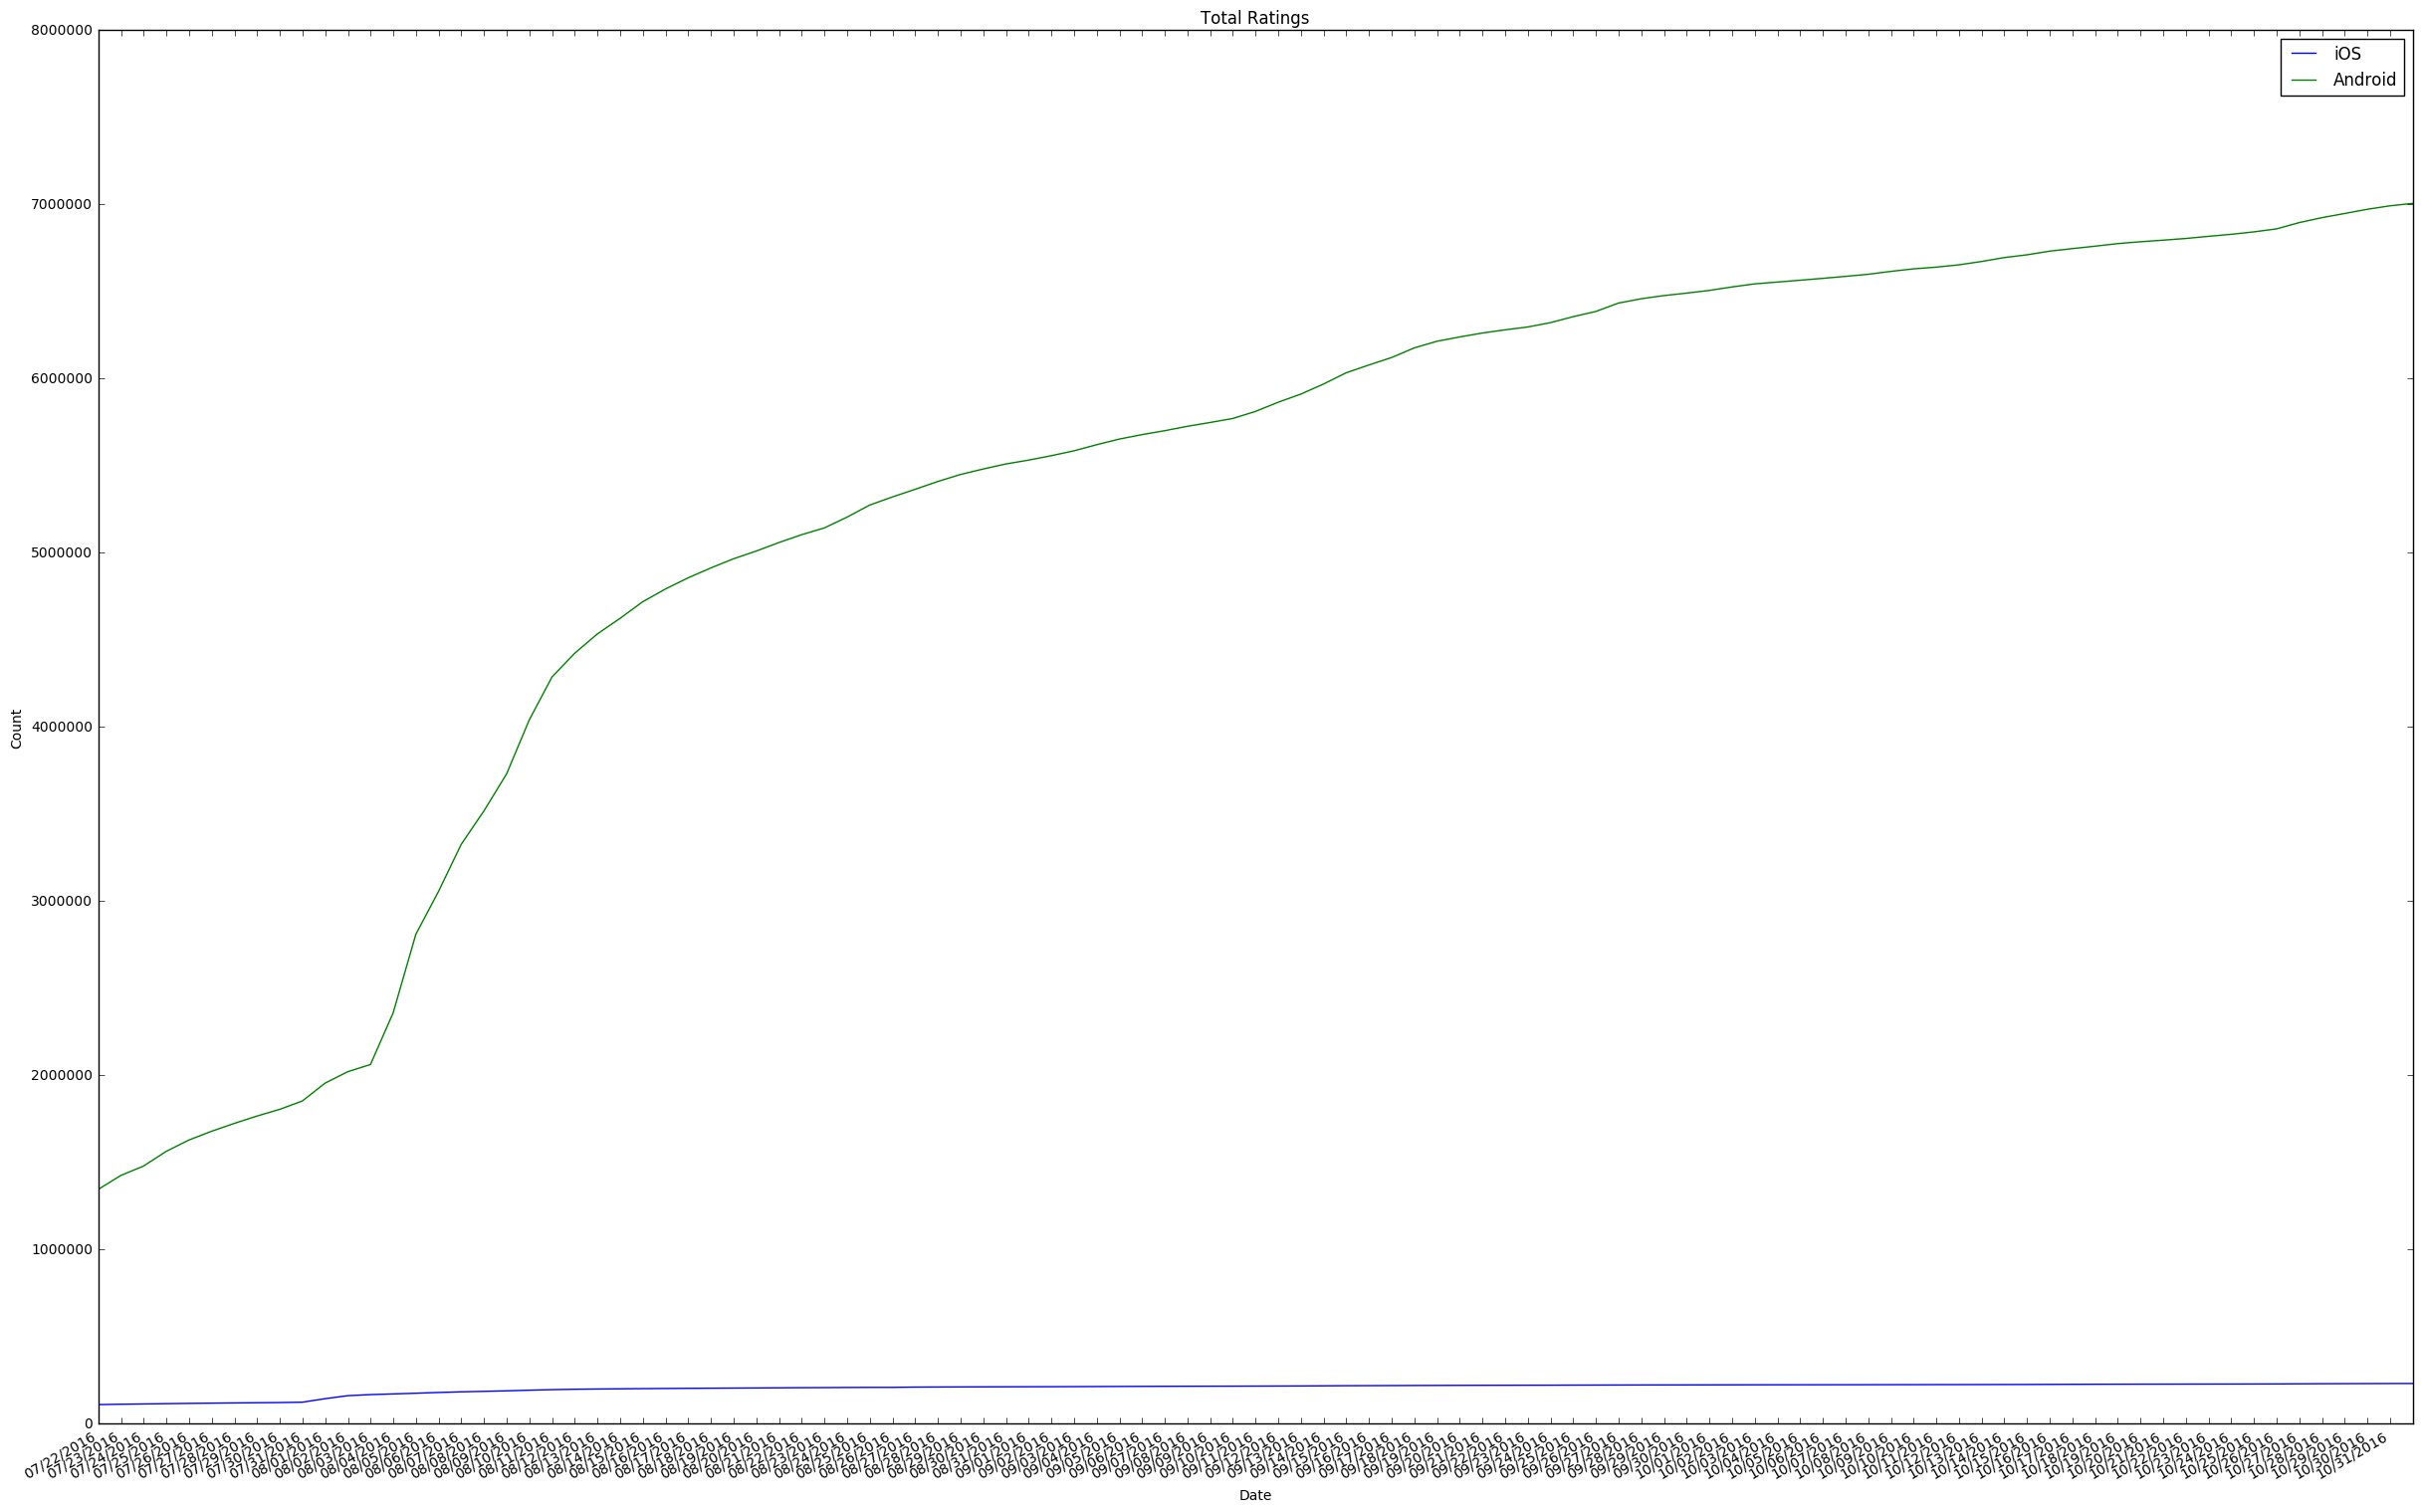

In [39]:
plt.subplots(figsize=(30,20))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.plot(ios_eod['dtg'],ios_eod['tot_rating'])
plt.plot(and_eod['dtg'],and_eod['total_ratings'])
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Total Ratings')
plt.legend(labels=['iOS','Android'])
plt.gcf().autofmt_xdate()

plt.savefig('total_ratings.png', dpi = 400)
plt.show()

### Graph of total Android Reviews by the number of stars

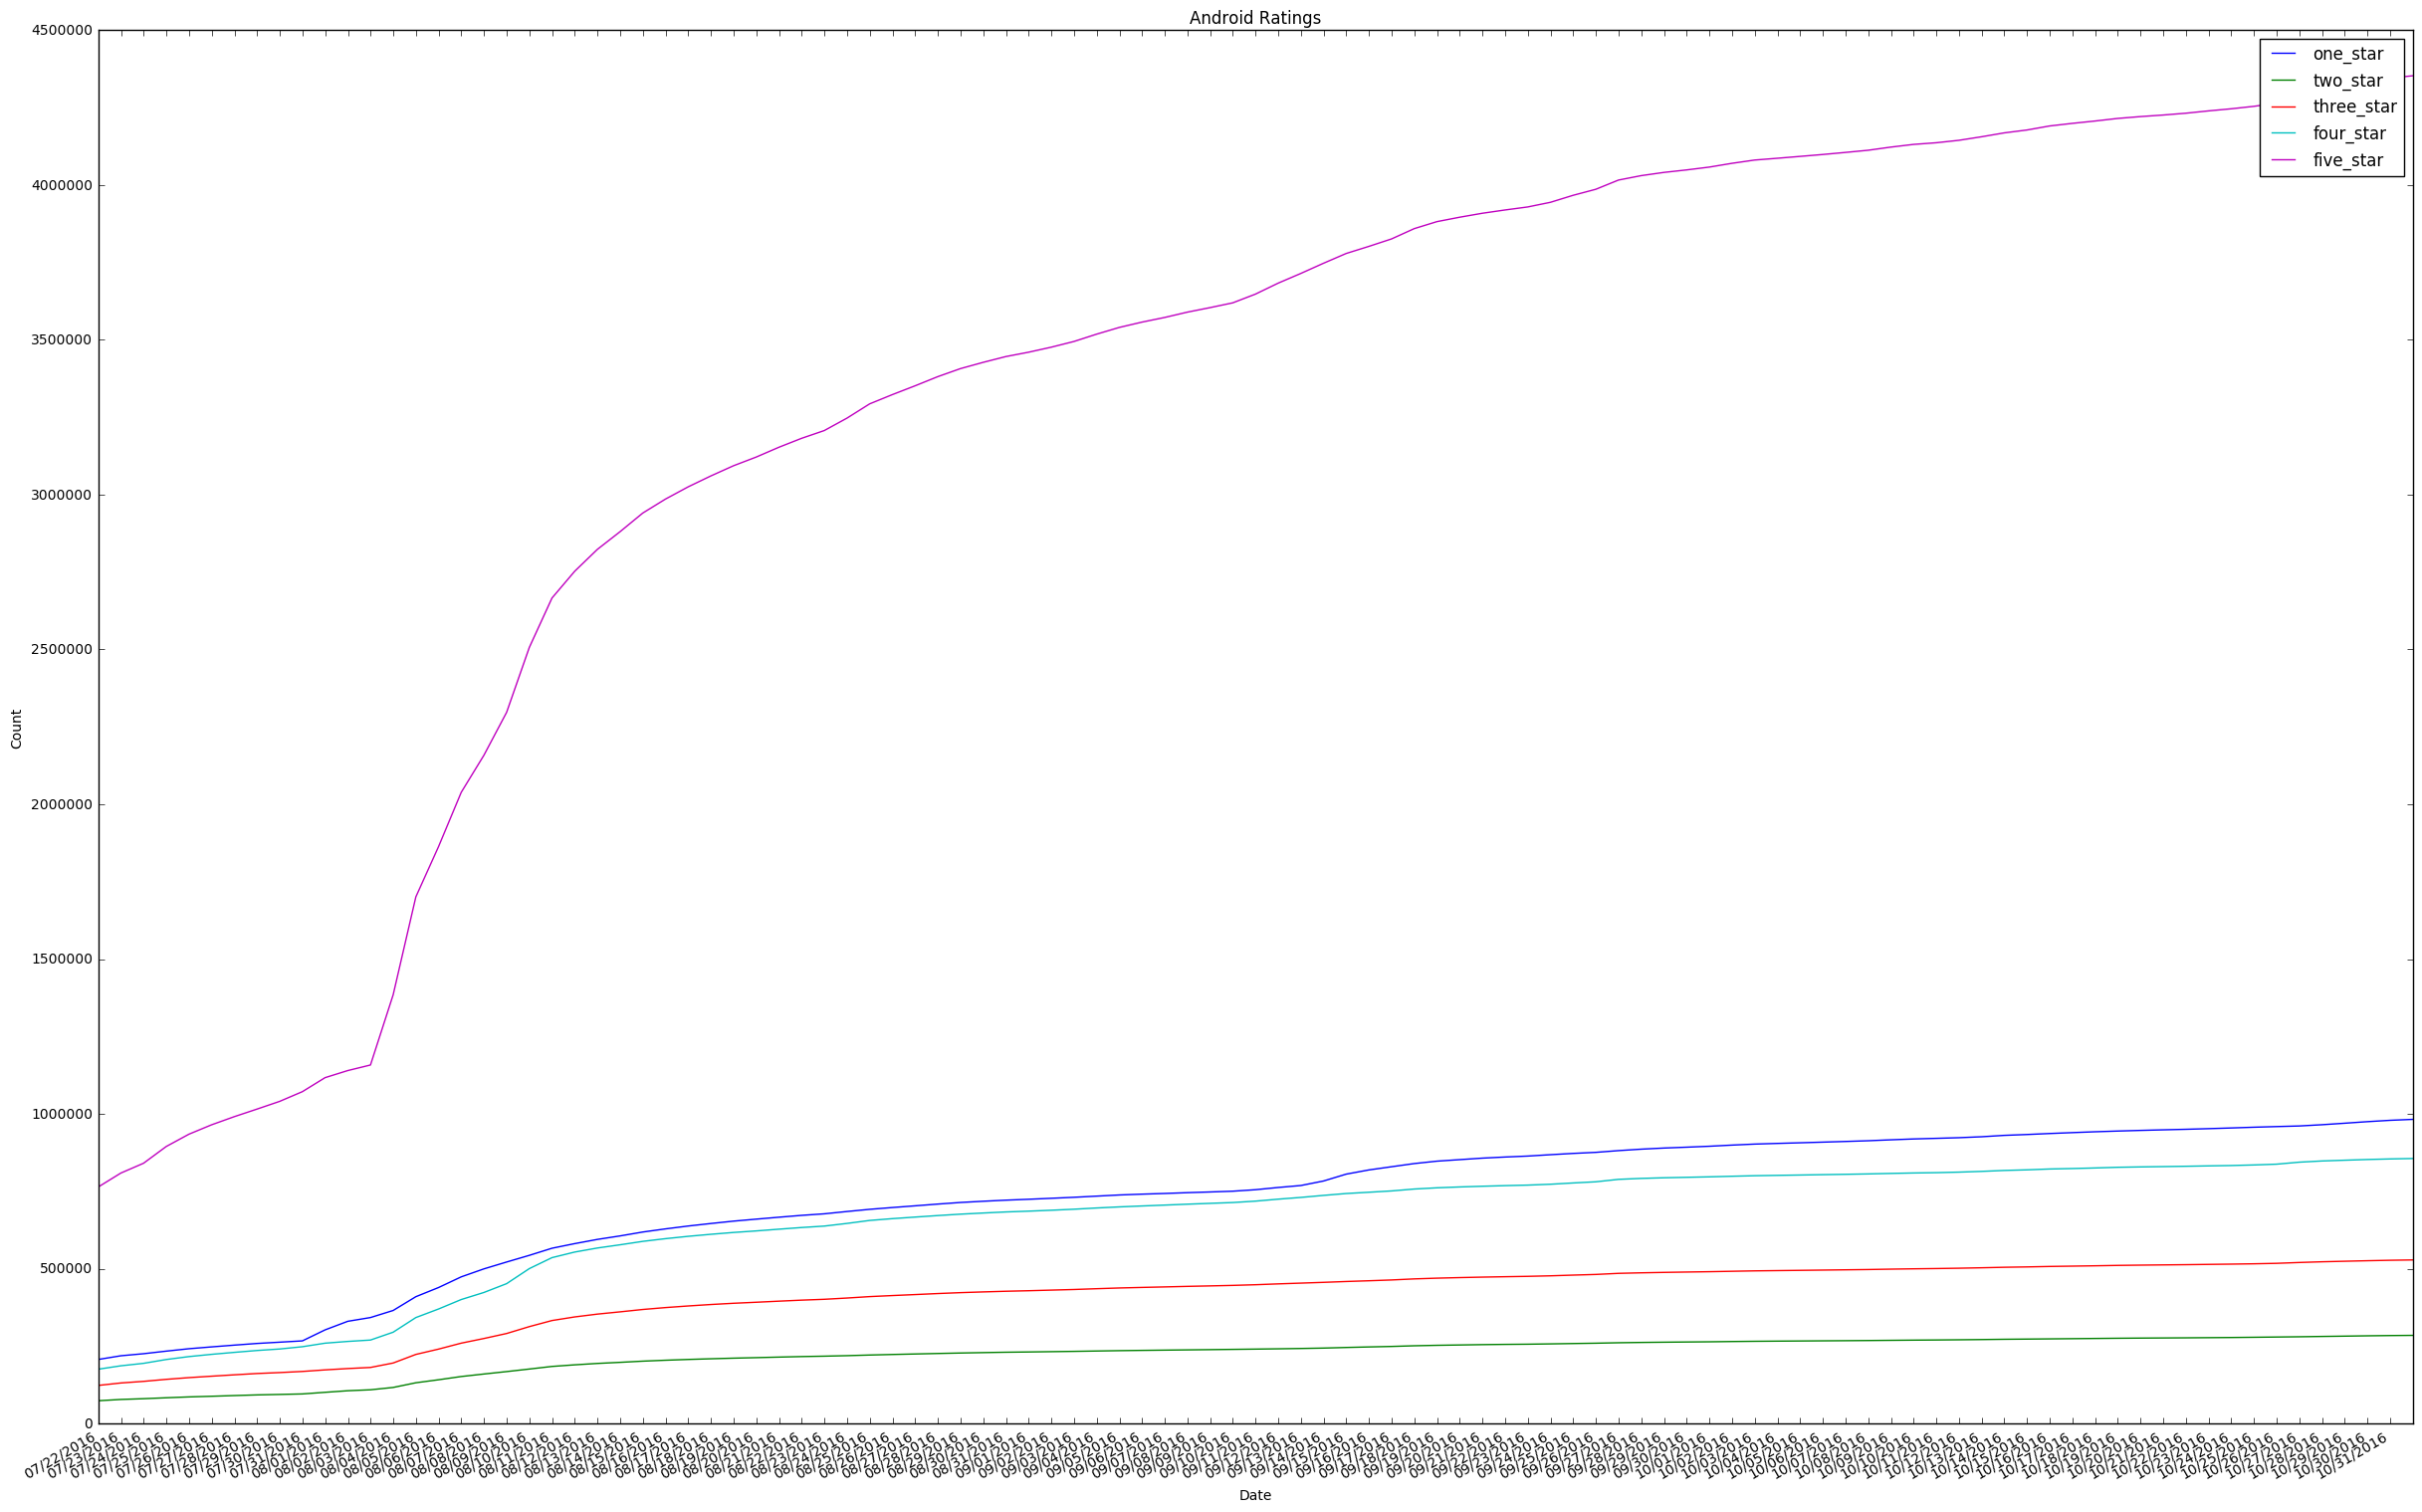

In [33]:
plt.subplots(figsize=(30,20))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.plot(and_eod['dtg'],and_eod['one_star'])
plt.plot(and_eod['dtg'],and_eod['two_star'])
plt.plot(and_eod['dtg'],and_eod['three_star'])
plt.plot(and_eod['dtg'],and_eod['four_star'])
plt.plot(and_eod['dtg'],and_eod['five_star'])
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Android Ratings')
plt.legend()
plt.gcf().autofmt_xdate()

plt.savefig('Android_Ratings.png', dpi = 400)
plt.show()

### Construct JSONs
modified table_p was used to format the dates as required

In [20]:
p = ': -'
table_p = string.maketrans(p, len(p) * "_")

In [18]:
def get_ios_date(row):
    date_dict = {}
    date_dict.update({'total_rating':ios_df['tot_ratings'][row]})
    date_dict.update({'total_rating_current_version':ios_df['curr_ratings'][row]})
    date_dict.update({'file_size': ios_df['size'][row]})
    date_dict.update({'version': ios_df['ver'][row]})
    date_dict.update({'description': ios_df['desc'][row]})
    return(date_dict)
    
ios_dates = {}
for x in range(0,len(ios_df)):
    ios_dates.update({str(ios_df['dtg'][x]).translate(table_p): get_ios_date(x)})

with open('pokemon_ios.json','w') as i:
    json.dump(ios_dates,i,indent=4)
print("iOS Dump Complete")

iOS Dump Complete


In [19]:
def get_and_date(row):
    date_dict = {}
    #print(date_values)
    date_dict.update({'average_rating':and_df['avg_score'][row]})
    date_dict.update({'total_rating':and_df['total_ratings'][row]})
    date_dict.update({'rating_1':and_df['one_star'][row]})
    date_dict.update({'rating_2':and_df['two_star'][row]})
    date_dict.update({'rating_3':and_df['three_star'][row]})
    date_dict.update({'rating_4':and_df['four_star'][row]})
    date_dict.update({'rating_5':and_df['five_star'][row]})
    date_dict.update({'file_size': and_df['size'][row]})
    date_dict.update({'version': and_df['version'][row]})
    date_dict.update({'description': and_df['desc'][row]})
    return(date_dict)

and_dates = {}
for x in range(0,len(and_df)):
    and_dates.update({str(and_df['dtg'][x]).translate(table_p): get_and_date(x)})

with open('pokemon_android.json','w') as a:
    json.dump(and_dates,a,indent=4)
print('Android JSON Completed')

Android JSON Completed
